# Imputing missing values with variants of IterativeImputer
- 일부 estimator를 `IterativeImputer`와 비교하여 어떤 estimator가 더 적합한지 확인

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

# 이 기능을 사용하려면 명시적으로 요청
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

N_SPLITS = 5

rng = np.random.RandomState(0)

In [2]:
X_full, y_full = fetch_california_housing(return_X_y=True)
# ~예제의 목적에 따라 2000개의 샘플이면 충분
# 오차 막대가 다른 느린 실행을 위해 다음 두 줄을 제거
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

In [3]:
# 누락된 값 없이 전체 데이터셋의 점수를 추정
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

In [4]:
# 각 행에 하나의 누락된 값을 추가
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# 대입 후 점수 추정(평균 및 중앙값 전략)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

In [5]:
# 다양한 추정자를 사용하여 결측값을 반복저으로 대입한 후 점수 추정
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # 제한된 실행 시간 동안 충분히 좋은 예측 성능을 얻을 수 있도록 RandomForestRegressor의 하이퍼 파라미터 조정
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
# 반복 임퍼터는 허용 오차에 민감하며 내부적으로 사용되는 추정자에 따라 달라짐
# 허용 오차 매개변수의 기본값을 크게 변경하지 않으면서도 제한된 계산 리소스로 예제를 실행할 수 있도록 허용 오차 조정
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

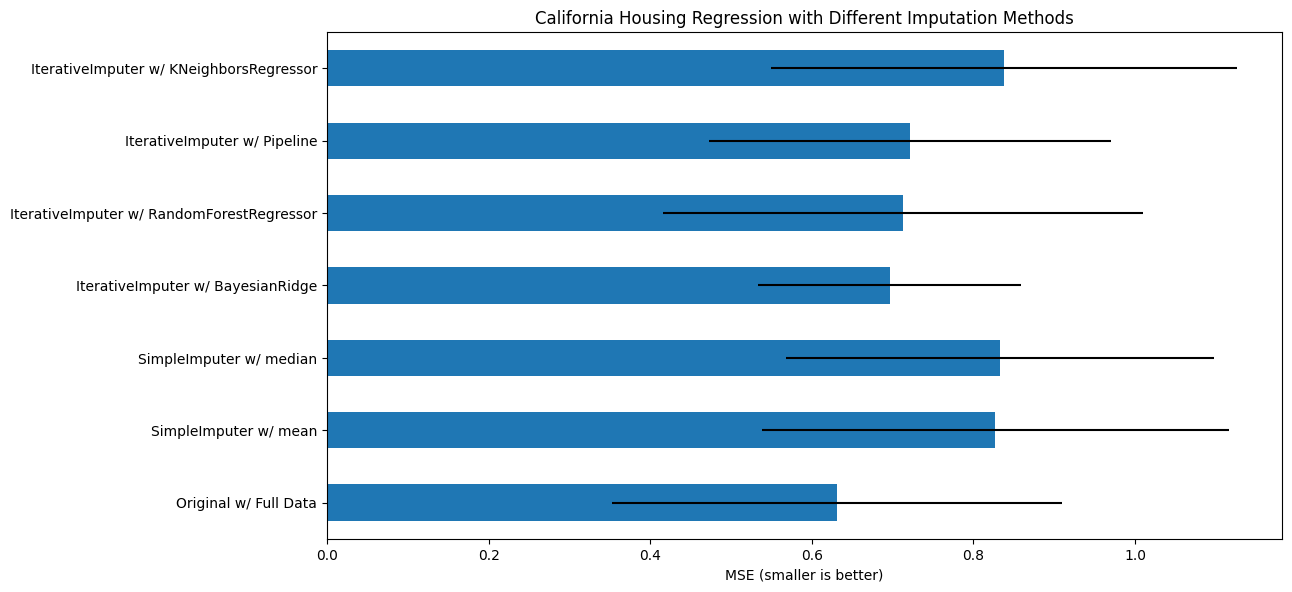

In [6]:
# 캘리포니아 주택 결과 그리기
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()